In [440]:
from scipy.stats import poisson
import copy
import os
import itertools
import pickle
import random
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
% matplotlib inline

In [441]:
distribution = 'poisson'
environment = 'simple'
exp_name = distribution + '_' + environment
results_dir = '/Users/kunal/Workspace/RL/car_rental_results/poisson_large/'
policy_dump_file = results_dir + 'predicted_policy_dump'
# policy_backup_file = results_dir + 'policy_backup_dump'
state_values_file = '/Users/kunal/Workspace/RL/car_rental_results/poisson_simple/state_values_dump'
with open(state_values_file, 'rb') as f:
    V_pred = pickle.load(f) 

In [442]:
num_stations = 2
moving_cost = 2
parking_cost = 4
max_parking_slots = 10
rent_reward = 10
moving_capacity = 5
cap0, cap1 = 20, 20
lambda_req0, lambda_req1 = 3, 4
lambda_ret0, lambda_ret1 = 3, 2

In [443]:
state_lists = [range(0, cap0 + 1), range(0, cap1 + 1)]
states = list(itertools.product(*state_lists))
actions = range(-moving_capacity, moving_capacity + 1, 1)
discount_rate = 0.9
if environment == 'simple':
    max_policy_eval_iterations = 10
else:
    max_policy_eval_iterations = 10
max_iterations = 20

In [444]:
# Plotting methods
def plot_policy(policy, acts):
#     fig = plt.figure()
#     ax = plt.subplot(111)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    for action in acts:
        action_states = [state for state in states if policy[state] == action]
        x_val = [elem[1] for elem in action_states]
        y_val = [elem[0] for elem in action_states] 
        ax.plot(x_val, y_val, label=action)
    ax.set_xlabel('#Cars at location 1')
    ax.set_ylabel('#Cars at location 0')
    ax.set_xlim(-0.5, cap1 + 0.5)
    ax.set_ylim(-0.5, cap0 + 0.5)
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_state_values(V, dim0, dim1):
    x = range(0, dim1 + 1)
    y = range(0, dim0 + 1)
    matrix = np.array([[V[(y_val, x_val)] for y_val in y] for x_val in x])
    sns.heatmap(matrix)

In [445]:
# Helper methods
def get_poisson_probability(req0, req1, ret0, ret1):
    if req0 < cap0:
        preq0 = poisson.pmf(req0, lambda_req0)
    else:
        preq0 = (1 - poisson.cdf(cap0 - 1, lambda_req0)) 
    
    if req1 < cap1:
        preq1 = poisson.pmf(req1, lambda_req1)
    else:
        preq1 = 1 - poisson.cdf(cap1 - 1, lambda_req1)
    
    if ret0 < cap0:
        pret0 = poisson.pmf(ret0, lambda_ret0)
    else:
        pret0 = 1 - poisson.cdf(cap0 - 1, lambda_ret0)
    
    if ret1 < cap1:
        pret1 = poisson.pmf(ret1, lambda_ret1)
    else:
        pret1 = 1 - poisson.cdf(cap1 - 1, lambda_ret1)

    return preq0 * preq1 * pret0 * pret1

def get_uniform_probability(req0_max, req1_max, ret0_max, ret1_max):
    preq0 = 1.0 / (req0_max + 1)
    preq1 = 1.0 / (req1_max + 1)
    pret0 = 1.0 / (ret0_max + 1)
    pret1 = 1.0 / (ret1_max + 1)
    return preq0 * preq1 * pret0 * pret1

def update_station(c, req, ret, cap, action):
    # Can't transfer more than current capacity
    if action > c:
        return -1, 0
    # Can't store more than max capacity
    avail = min(cap, c - action)
    # Give cars for rent
    c_next = min(0, avail - req)
    # Compute reward
    reward = min(avail, req) * rent_reward
    # Add back returned cars
    c_next = min(cap, c_next + ret) 
    return c_next, reward
    
def exp_poisson_value(state, action, V):
    c0, c1 = state[0], state[1]
    assert (c0 <= cap0) and (c1 <= cap1)
    exp_value = 0
    early_exit = 0
    num_iterations = 1000
    for i in range(0, num_iterations):
        req0, req1, ret0, ret1 = np.random.poisson(lam=(lambda_req0, lambda_req1, lambda_ret0, lambda_ret1))
        c0_next, reward0 = update_station(c0, req0, ret0, cap0, action)
        c1_next, reward1 = update_station(c1, req1, ret1, cap1, -action)
        if (c0_next < 0) or (c1_next < 0):
            early_exit += 1
            continue
        # Compute discounted value
        next_state = (c0_next, c1_next)
        total_reward = reward0 + reward1 - get_cost(c0, c1, action)
        exp_value += (total_reward + discount_rate * V[next_state])
    return (exp_value / num_iterations)

def get_uniform_max_value(x):
    y = 2 * x
    if x % 2 != 0:
        y += 1
    return y

def get_cost(c0, c1, action):
    cost = 0
    if environment == 'complex':
        if action > 0:
            cost = abs(action - 1) * moving_cost
        else:
            cost = abs(action) * moving_cost
        if c0 > max_parking_slots:
            cost += parking_cost
        if c1 > max_parking_slots:
            cost += parking_cost
    else:
        cost = abs(action) * moving_cost
    return cost
    
def exp_uniform_value(state, action, V):
    c0, c1 = state[0], state[1]
    assert (c0 <= cap0) and (c1 <= cap1)
    exp_value = 0
    req0_max = get_uniform_max_value(lambda_req0)
    req1_max = get_uniform_max_value(lambda_req1)
    ret0_max = get_uniform_max_value(lambda_ret0)
    ret1_max = get_uniform_max_value(lambda_ret1)
#     print req0_max, req1_max, ret0_max, ret1_max
    i = 0
    for req0 in range(0, req0_max + 1):
        for req1 in range(0, req1_max + 1):
            for ret0 in range(0, ret0_max + 1):
                c0_next, reward0 = update_station(c0, req0, ret0, cap0, action)
                if c0_next < 0:
                    continue
                for ret1 in range(0, ret1_max + 1):
#                     print('Req0: {0} Req1: {1} Ret0: {2} Ret1: {3}'.format(req0, req1, ret0, ret1))
                    c1_next, reward1 = update_station(c1, req1, ret1, cap1, -action)
                    if c1_next < 0:
                        continue
#                     print (c0, c1, c0_next, c1_next, reward0, reward1)
                    # Compute discounted value
                    next_state = (c0_next, c1_next)
                    total_reward = reward0 + reward1 - get_cost(c0, c1, action)
                    probability = get_uniform_probability(req0_max, req1_max, ret0_max, ret1_max)
                    exp_value += probability * (total_reward + discount_rate * V[next_state])
#                     i += 1
#                     if i == 1000:
#                         return exp_value
    return exp_value

def get_exp_value(state, action, V):
    if distribution == 'uniform_non_symmetric':
        return exp_uniform_value(state, action, V)
    return exp_poisson_value(state, action, V)

In [446]:
# Policy Iteration methods
def policy_eval(policy, V):
    theota = 0.0001
    iteration = 0
    while True and iteration < max_policy_eval_iterations:
        iteration += 1
        delta = 0
        for state in states:
            v = V[state]
            V[state] = get_exp_value(state, policy[state], V)
            delta = max(delta, abs(v - V[state]))
        print('Iteration = {0} Delta = {1}'.format(iteration, delta))
        if delta < theota:
            print('Policy evaluation converged after {0} iterations. Max Delta = {1}\n'.format(iteration, delta))
            break
        
def policy_improvement(policy, V, state_space):
    policy_stable = True
    stable_states = 0
    for state in state_space:
        if (state[0] % 2) == 0 and (state[1] % 10) == 0:
            policy_backup = copy.deepcopy(policy)
        if (state[0] == 0) and (state[1] == 0):
            policy[state] = 0
            continue
#         print('\nFinding best action for state {0}'.format(state))
        old_action = policy[state]
        max_value, max_action = 0, None
        for action in actions:
            if (action > state[0]) or (-action > state[1]):
                continue
#             print('Evaluating action: {0}'.format(action))
            value = get_exp_value(state, action, V)
#             print('Action value: {0}'.format(value))
            if (max_action is None):
                max_action = action
                max_value = value
                continue
            # If two policies have same values choose the one which shifts lesser number of cars
            if (max_value < value) or (max_value == value and abs(max_action) > abs(action)):
#                 print('Updating max value action to {0}'.format(action))
                max_value = value
                max_action = action
        assert max_action is not None
        policy[state] = max_action
        if old_action == policy[state]:
            stable_states += 1
        else:
            policy_stable = False
    print('\n#Stable States:{0} Policy Stable: {1}'.format(stable_states, policy_stable))
    return policy_stable

def policy_iteration(V):
    # Initialize policy randomly
    policy = {state : 0 for state in states}
    # Dictionary to store policy at each iteration
    policy_dump = {0: copy.deepcopy(policy)}
    # Initialize all states to 0
#     V = {state : 0 for state in states}
    policy_stable = False
    iteration = 1
    while not policy_stable and iteration < max_iterations:
        print '\nExecuting policy eval iter:{0}'.format(iteration)
        policy_eval(policy, V)
        print '\nExecuting policy improvement iter:{0}'.format(iteration)
        policy_stable = policy_improvement(policy, V, states)
        # Store policy for plotting later
        policy_dump[iteration] = copy.deepcopy(policy)
        iteration += 1
        plot_policy(policy, actions)
    return V, policy, policy_dump

def get_policy(V):
    # Initialize policy with 0
    policy = {state : 0 for state in states}
    policy_stable = policy_improvement(policy, V, states)
    return policy


Executing policy eval iter:1
Iteration = 1 Delta = 165.520962025
Iteration = 2 Delta = 4.85772733826
Iteration = 3 Delta = 5.47076388802
Iteration = 4 Delta = 6.42946662616
Iteration = 5 Delta = 5.14620406896
Iteration = 6 Delta = 3.66569033289
Iteration = 7 Delta = 5.14402469972
Iteration = 8 Delta = 4.99440056697
Iteration = 9 Delta = 5.23835777573
Iteration = 10 Delta = 5.61454988817

Executing policy improvement iter:1

#Stable States:206 Policy Stable: False


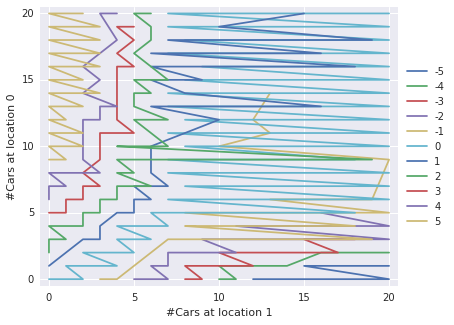


Executing policy eval iter:2
Iteration = 1 Delta = 71.9690110409
Iteration = 2 Delta = 10.5242304339
Iteration = 3 Delta = 5.91877488644
Iteration = 4 Delta = 5.04574751832
Iteration = 5 Delta = 5.28845366681
Iteration = 6 Delta = 5.63970820038
Iteration = 7 Delta = 4.21724727404
Iteration = 8 Delta = 4.39045656491
Iteration = 9 Delta = 6.89079188725
Iteration = 10 Delta = 4.57474711318

Executing policy improvement iter:2

#Stable States:309 Policy Stable: False


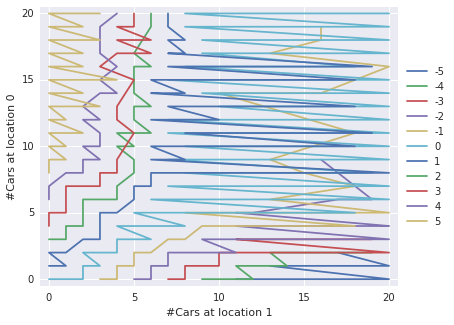


Executing policy eval iter:3
Iteration = 1 Delta = 5.27607661261
Iteration = 2 Delta = 4.69929140889
Iteration = 3 Delta = 4.42572977409
Iteration = 4 Delta = 4.22162793896
Iteration = 5 Delta = 4.81680152463
Iteration = 6 Delta = 4.56083736527
Iteration = 7 Delta = 4.88358273508
Iteration = 8 Delta = 5.12596843862
Iteration = 9 Delta = 6.46126511462
Iteration = 10 Delta = 5.13665735841

Executing policy improvement iter:3

#Stable States:293 Policy Stable: False


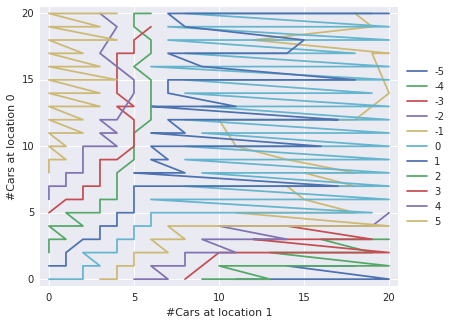


Executing policy eval iter:4
Iteration = 1 Delta = 5.94932571442
Iteration = 2 Delta = 5.71266862637
Iteration = 3 Delta = 4.52884919385
Iteration = 4 Delta = 5.04424032581
Iteration = 5 Delta = 4.69327994929
Iteration = 6 Delta = 4.54693514216
Iteration = 7 Delta = 4.64829080465
Iteration = 8 Delta = 5.01052668926
Iteration = 9 Delta = 5.23208202006
Iteration = 10 Delta = 4.90256086303

Executing policy improvement iter:4

#Stable States:300 Policy Stable: False


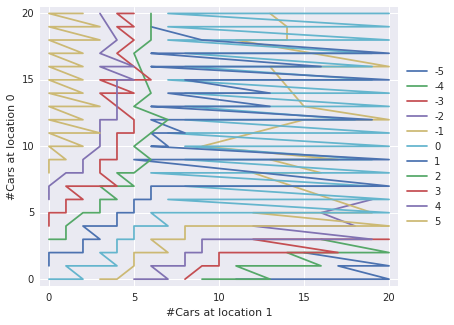


Executing policy eval iter:5
Iteration = 1 Delta = 6.84969204009
Iteration = 2 Delta = 4.89163754047
Iteration = 3 Delta = 5.17623291535
Iteration = 4 Delta = 5.35152004012
Iteration = 5 Delta = 6.04561215523
Iteration = 6 Delta = 5.14548328563
Iteration = 7 Delta = 4.268978587
Iteration = 8 Delta = 5.77063675714
Iteration = 9 Delta = 4.01352109504
Iteration = 10 Delta = 4.69265283618

Executing policy improvement iter:5

#Stable States:307 Policy Stable: False


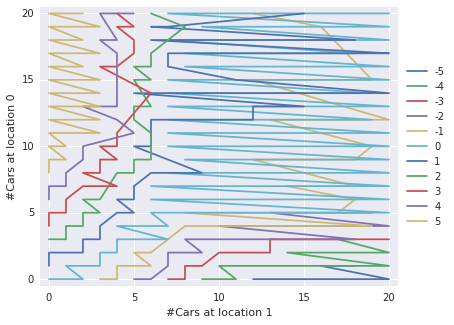


Executing policy eval iter:6
Iteration = 1 Delta = 6.22462076642
Iteration = 2 Delta = 4.9619506753
Iteration = 3 Delta = 5.18349224117
Iteration = 4 Delta = 4.42245217505
Iteration = 5 Delta = 4.37112167399
Iteration = 6 Delta = 5.77799784905
Iteration = 7 Delta = 4.62569375619
Iteration = 8 Delta = 4.82197859119
Iteration = 9 Delta = 5.54581813741
Iteration = 10 Delta = 5.18179048336

Executing policy improvement iter:6

#Stable States:298 Policy Stable: False


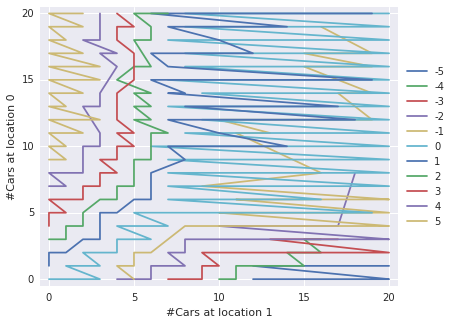


Executing policy eval iter:7
Iteration = 1 Delta = 6.27605062379
Iteration = 2 Delta = 5.27505258451
Iteration = 3 Delta = 4.95660393454
Iteration = 4 Delta = 4.50284220051
Iteration = 5 Delta = 5.08757036934
Iteration = 6 Delta = 6.23262606212
Iteration = 7 Delta = 4.81549275227
Iteration = 8 Delta = 4.76593839299
Iteration = 9 Delta = 5.06545719782
Iteration = 10 Delta = 4.48309409585

Executing policy improvement iter:7

#Stable States:287 Policy Stable: False


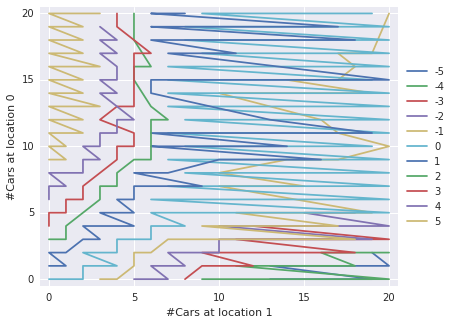


Executing policy eval iter:8
Iteration = 1 Delta = 5.93322484556
Iteration = 2 Delta = 4.92840699103
Iteration = 3 Delta = 5.38826538373
Iteration = 4 Delta = 4.21694814592
Iteration = 5 Delta = 6.36626407489
Iteration = 6 Delta = 5.89225806629
Iteration = 7 Delta = 4.24353998206
Iteration = 8 Delta = 5.19538015041
Iteration = 9 Delta = 4.83094654077
Iteration = 10 Delta = 4.93788960994

Executing policy improvement iter:8

#Stable States:297 Policy Stable: False


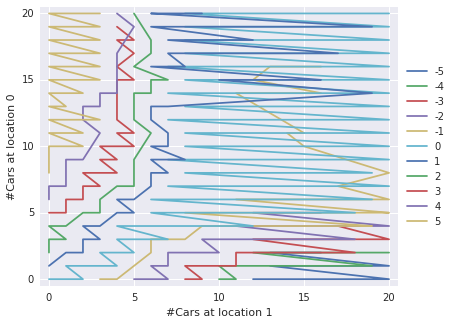


Executing policy eval iter:9
Iteration = 1 Delta = 6.43596921253
Iteration = 2 Delta = 4.94621823217
Iteration = 3 Delta = 4.99385471257
Iteration = 4 Delta = 4.04130365602
Iteration = 5 Delta = 4.4271414437
Iteration = 6 Delta = 4.00120284754
Iteration = 7 Delta = 4.74460451306
Iteration = 8 Delta = 5.44239605453
Iteration = 9 Delta = 4.84237826834
Iteration = 10 Delta = 5.09629762945

Executing policy improvement iter:9

#Stable States:310 Policy Stable: False


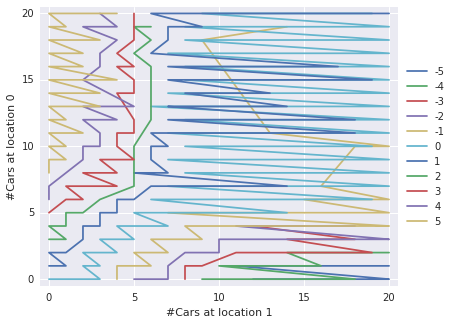


Executing policy eval iter:10
Iteration = 1 Delta = 6.44660553699
Iteration = 2 Delta = 4.46212456768
Iteration = 3 Delta = 4.35396435459
Iteration = 4 Delta = 6.44501599018
Iteration = 5 Delta = 4.67601566797
Iteration = 6 Delta = 4.77901185614
Iteration = 7 Delta = 5.65454536728
Iteration = 8 Delta = 6.38234928694
Iteration = 9 Delta = 5.365559996
Iteration = 10 Delta = 4.50380476526

Executing policy improvement iter:10

#Stable States:307 Policy Stable: False


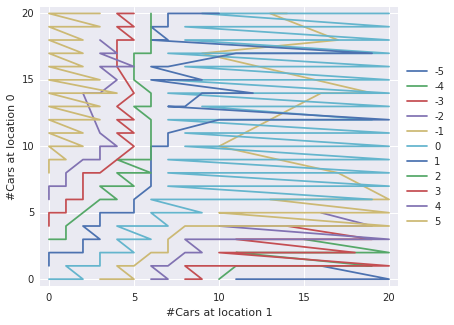


Executing policy eval iter:11
Iteration = 1 Delta = 4.96758508897
Iteration = 2 Delta = 5.25242731391
Iteration = 3 Delta = 4.72794506163
Iteration = 4 Delta = 4.46745800868
Iteration = 5 Delta = 5.6133450669
Iteration = 6 Delta = 5.26153487605
Iteration = 7 Delta = 5.70161649948
Iteration = 8 Delta = 5.2251084818
Iteration = 9 Delta = 4.19035187819
Iteration = 10 Delta = 4.74280604978

Executing policy improvement iter:11

#Stable States:299 Policy Stable: False


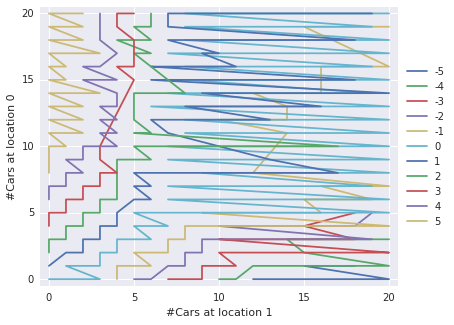


Executing policy eval iter:12
Iteration = 1 Delta = 5.47090036989
Iteration = 2 Delta = 4.91210720074
Iteration = 3 Delta = 4.21892890925
Iteration = 4 Delta = 4.41679272875
Iteration = 5 Delta = 4.32826530581
Iteration = 6 Delta = 4.40696718916
Iteration = 7 Delta = 5.78193280911
Iteration = 8 Delta = 3.87408061329
Iteration = 9 Delta = 4.90366452999
Iteration = 10 Delta = 4.57720359663

Executing policy improvement iter:12

#Stable States:299 Policy Stable: False


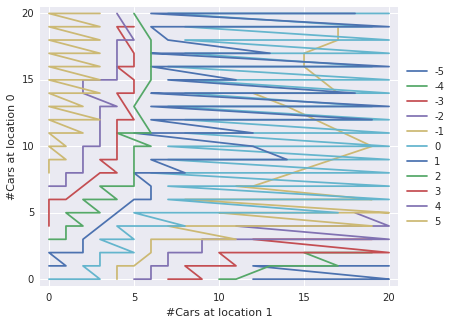


Executing policy eval iter:13
Iteration = 1 Delta = 5.87985113375
Iteration = 2 Delta = 4.69555407087
Iteration = 3 Delta = 5.42339199849
Iteration = 4 Delta = 5.29307701041
Iteration = 5 Delta = 4.844379083
Iteration = 6 Delta = 4.83483647664
Iteration = 7 Delta = 4.88493373214
Iteration = 8 Delta = 5.24175273398
Iteration = 9 Delta = 4.93737380221
Iteration = 10 Delta = 4.8603763258

Executing policy improvement iter:13

#Stable States:295 Policy Stable: False


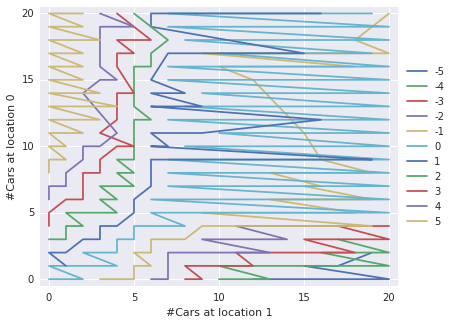


Executing policy eval iter:14
Iteration = 1 Delta = 5.23643657119
Iteration = 2 Delta = 4.81587994452
Iteration = 3 Delta = 6.19502688828
Iteration = 4 Delta = 5.25464820135
Iteration = 5 Delta = 5.4379008252
Iteration = 6 Delta = 4.72325563299
Iteration = 7 Delta = 4.73742414309
Iteration = 8 Delta = 5.32765164964
Iteration = 9 Delta = 4.93812654249
Iteration = 10 Delta = 5.10679777722

Executing policy improvement iter:14

#Stable States:278 Policy Stable: False


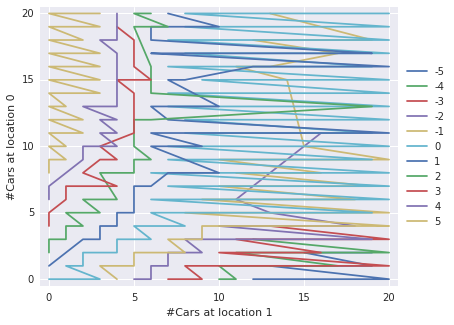


Executing policy eval iter:15
Iteration = 1 Delta = 6.78022561058
Iteration = 2 Delta = 4.59415460505
Iteration = 3 Delta = 4.88651892599
Iteration = 4 Delta = 5.98471364669
Iteration = 5 Delta = 6.03493635768
Iteration = 6 Delta = 4.88362676023
Iteration = 7 Delta = 6.00782962468
Iteration = 8 Delta = 4.91726904398
Iteration = 9 Delta = 4.92238901818
Iteration = 10 Delta = 5.02849536538

Executing policy improvement iter:15

#Stable States:286 Policy Stable: False


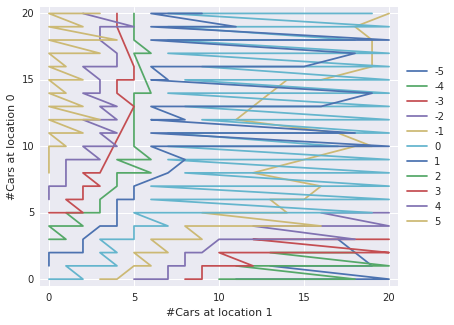


Executing policy eval iter:16
Iteration = 1 Delta = 6.39068872754
Iteration = 2 Delta = 5.19779292897
Iteration = 3 Delta = 4.95524372704
Iteration = 4 Delta = 4.54148277337
Iteration = 5 Delta = 5.54054101886
Iteration = 6 Delta = 5.30530005614
Iteration = 7 Delta = 5.43195039903
Iteration = 8 Delta = 6.2950600725
Iteration = 9 Delta = 4.50626126142
Iteration = 10 Delta = 4.71506965365

Executing policy improvement iter:16

#Stable States:279 Policy Stable: False


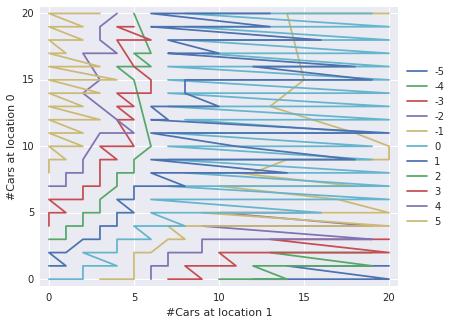


Executing policy eval iter:17
Iteration = 1 Delta = 6.00774894736
Iteration = 2 Delta = 4.74840140593
Iteration = 3 Delta = 4.6607353758
Iteration = 4 Delta = 4.66260340327
Iteration = 5 Delta = 5.07346235466
Iteration = 6 Delta = 4.77169511072
Iteration = 7 Delta = 4.91877714629
Iteration = 8 Delta = 5.04699635481
Iteration = 9 Delta = 4.96656058553
Iteration = 10 Delta = 5.3120000058

Executing policy improvement iter:17

#Stable States:293 Policy Stable: False


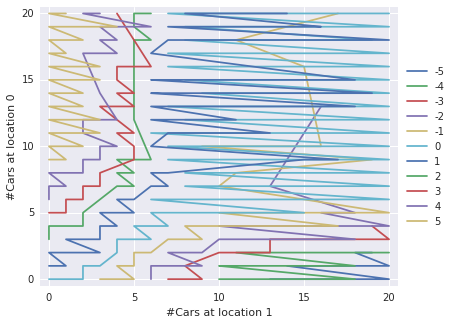


Executing policy eval iter:18
Iteration = 1 Delta = 5.85984885985
Iteration = 2 Delta = 4.3179064805
Iteration = 3 Delta = 5.20466259657
Iteration = 4 Delta = 5.25932155924
Iteration = 5 Delta = 5.35872719365
Iteration = 6 Delta = 4.65727931418
Iteration = 7 Delta = 5.94188963918
Iteration = 8 Delta = 6.41652402485
Iteration = 9 Delta = 6.29459171923
Iteration = 10 Delta = 4.77026355365

Executing policy improvement iter:18

#Stable States:288 Policy Stable: False


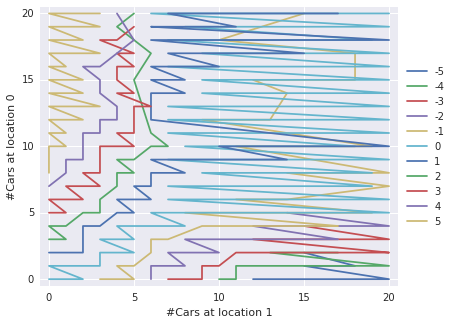


Executing policy eval iter:19
Iteration = 1 Delta = 7.36695439551
Iteration = 2 Delta = 5.18936877923
Iteration = 3 Delta = 4.39878763227
Iteration = 4 Delta = 4.91544411831
Iteration = 5 Delta = 5.32721104112
Iteration = 6 Delta = 4.97436206749
Iteration = 7 Delta = 5.0523064589
Iteration = 8 Delta = 5.31710589078
Iteration = 9 Delta = 6.66179918393
Iteration = 10 Delta = 4.84870275435

Executing policy improvement iter:19

#Stable States:291 Policy Stable: False


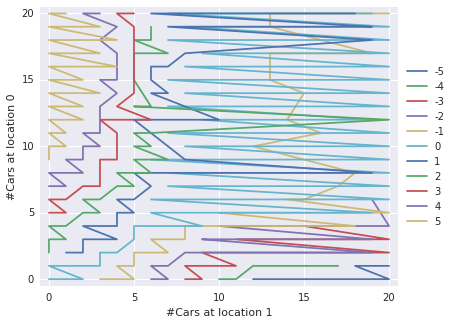

In [447]:
# policy_pred = get_policy(V_pred)
V_final, policy_pred, policy_dump = policy_iteration(V_pred)
# print(exp_uniform_value((20, 0), 0, V_pred))

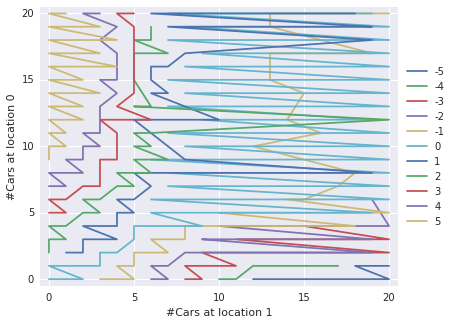

In [448]:
plot_policy(policy_pred, actions)

In [449]:
with open(policy_dump_file, 'wb') as f:
    pickle.dump(policy_pred, f)